## Modeling FEMA data with Census Bureau Data Combined

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
import datetime as dt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup     
import re
from nltk.corpus import stopwords

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv("fema_qwi_data")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195719 entries, 0 to 195718
Data columns (total 47 columns):
Unnamed: 0                    195719 non-null int64
state_abv                     195719 non-null object
county_name                   195719 non-null object
qtime                         195719 non-null object
county                        193457 non-null float64
EarnBeg                       193260 non-null float64
EarnHirAS                     189737 non-null float64
EarnHirNS                     189081 non-null float64
EarnS                         190054 non-null float64
EarnSepS                      186468 non-null float64
Emp                           193099 non-null float64
EmpEnd                        190060 non-null float64
EmpS                          189973 non-null float64
EmpSpv                        193011 non-null float64
EmpTotal                      193152 non-null float64
FrmJbC                        189904 non-null float64
FrmJbCS                       

In [4]:
# dropping the unnamed column 
df.drop(columns=["Unnamed: 0", "time_y", "time_x", "Unnamed: 0.1"], inplace=True)

In [5]:
df.head()

state_abv                                        county_name   qtime  \
0        AK  Alaska Gateway Regional Educational Attendance...  2009Q2   
1        AK  Alaska Gateway Regional Educational Attendance...  2012Q3   
2        AK  Alaska Gateway Regional Educational Attendance...  2013Q2   
3        AK                             Aleutians East Borough  2003Q1   
4        AK                             Aleutians East Borough  2003Q1   

   county  EarnBeg  EarnHirAS  EarnHirNS   EarnS  EarnSepS    Emp  \
0     NaN      NaN        NaN        NaN     NaN       NaN    NaN   
1     NaN      NaN        NaN        NaN     NaN       NaN    NaN   
2     NaN      NaN        NaN        NaN     NaN       NaN    NaN   
3    13.0   1744.0        NaN        NaN  1744.0       NaN    NaN   
4    13.0   2210.0     1293.0     1443.0  2307.0    1775.0  744.0   

              ...              HM Program Declared  Declaration Date  \
0             ...                              Yes         6/11/2009   
1             ...                              Yes        11/27/2012   
2             ...                              Yes         6/25/2013   
3             ...                              NaN               NaN   
4             ...                              NaN               NaN   

   Disaster Type    Incident Type  \
0             DR            Flood   
1             DR  Severe Storm(s)   
2             DR            Flood   
3            NaN              NaN   
4            NaN              NaN   

                                               Title  Incident Begin Date  \
0                              FLOODING AND ICE JAMS           2009-04-28   
1  SEVERE STORM, STRAIGHT-LINE WINDS, FLOODING, A...           2012-09-15   
2                                           FLOODING           2013-05-17   
3                                                NaN                  NaN   
4                                                NaN                  NaN   

   Incident End Date  Place Code  Declaration Request Number  \
0         2009-05-31      1255.0                      9077.0   
1         2012-09-30      1255.0                     12124.0   
2         2013-06-11      1255.0                     13035.0   
3                NaN         NaN                         NaN   
4                NaN         NaN                         NaN   

       Incident Duration Days  
0  33 days 00:00:00.000000000  
1  15 days 00:00:00.000000000  
2  25 days 00:00:00.000000000  
3                         NaN  
4                         NaN  

[5 rows x 43 columns]

In [6]:
df.dtypes

state_abv                      object
county_name                    object
qtime                          object
county                        float64
EarnBeg                       float64
EarnHirAS                     float64
EarnHirNS                     float64
EarnS                         float64
EarnSepS                      float64
Emp                           float64
EmpEnd                        float64
EmpS                          float64
EmpSpv                        float64
EmpTotal                      float64
FrmJbC                        float64
FrmJbCS                       float64
FrmJbGn                       float64
FrmJbGnS                      float64
FrmJbLs                       float64
FrmJbLsS                      float64
HirA                          float64
HirAEnd                       float64
HirAEndR                      float64
HirAEndRepl                   float64
HirAEndReplr                  float64
HirAs                         float64
Payroll     

In [7]:
df["Incident Begin Date"] = pd.to_datetime(df["Incident Begin Date"])

In [8]:
df["Incident End Date"] = pd.to_datetime(df["Incident End Date"])

In [9]:
df.dtypes

state_abv                             object
county_name                           object
qtime                                 object
county                               float64
EarnBeg                              float64
EarnHirAS                            float64
EarnHirNS                            float64
EarnS                                float64
EarnSepS                             float64
Emp                                  float64
EmpEnd                               float64
EmpS                                 float64
EmpSpv                               float64
EmpTotal                             float64
FrmJbC                               float64
FrmJbCS                              float64
FrmJbGn                              float64
FrmJbGnS                             float64
FrmJbLs                              float64
FrmJbLsS                             float64
HirA                                 float64
HirAEnd                              float64
HirAEndR  

In [10]:
from datetime import date

In [11]:
# taking the difference between the two date time to get the numbers of days 
df["Incident Duration Day"] = df["Incident End Date"] - df["Incident Begin Date"]

In [12]:
# converting the date time difference to just days
df["Incident Duration Day"] = df["Incident Duration Day"].astype('timedelta64[D]')

In [13]:
# finally turnng the date time to float numerical numbers
df["Incident Duration Day"] = df["Incident Duration Day"].astype(float)

In [14]:
df.dtypes

state_abv                             object
county_name                           object
qtime                                 object
county                               float64
EarnBeg                              float64
EarnHirAS                            float64
EarnHirNS                            float64
EarnS                                float64
EarnSepS                             float64
Emp                                  float64
EmpEnd                               float64
EmpS                                 float64
EmpSpv                               float64
EmpTotal                             float64
FrmJbC                               float64
FrmJbCS                              float64
FrmJbGn                              float64
FrmJbGnS                             float64
FrmJbLs                              float64
FrmJbLsS                             float64
HirA                                 float64
HirAEnd                              float64
HirAEndR  

In [15]:
df.drop(columns="Incident Duration Days", inplace=True)

In [16]:
# filling incident duration days that have a null value with 0
df["Incident Duration Day"].fillna(0, inplace=True)

In [17]:
# defining the columns that need to be filled with values from nan
col = ["Disaster Type", "Incident Type", "Title"]

# filling the null values that have nothing with no
df.update(df[col].fillna("None"))

In [18]:
# filling the Program Declared Programs null values to null with No
col_program = ["HM Program Declared", "IH Program Declared", "IA Program Declared", "PA Program Declared"]

df[col_program] = df[col_program].fillna("No")

In [19]:
df.head()

state_abv                                        county_name   qtime  \
0        AK  Alaska Gateway Regional Educational Attendance...  2009Q2   
1        AK  Alaska Gateway Regional Educational Attendance...  2012Q3   
2        AK  Alaska Gateway Regional Educational Attendance...  2013Q2   
3        AK                             Aleutians East Borough  2003Q1   
4        AK                             Aleutians East Borough  2003Q1   

   county  EarnBeg  EarnHirAS  EarnHirNS   EarnS  EarnSepS    Emp  \
0     NaN      NaN        NaN        NaN     NaN       NaN    NaN   
1     NaN      NaN        NaN        NaN     NaN       NaN    NaN   
2     NaN      NaN        NaN        NaN     NaN       NaN    NaN   
3    13.0   1744.0        NaN        NaN  1744.0       NaN    NaN   
4    13.0   2210.0     1293.0     1443.0  2307.0    1775.0  744.0   

           ...            HM Program Declared  Declaration Date  \
0          ...                            Yes         6/11/2009   
1          ...                            Yes        11/27/2012   
2          ...                            Yes         6/25/2013   
3          ...                             No               NaN   
4          ...                             No               NaN   

   Disaster Type    Incident Type  \
0             DR            Flood   
1             DR  Severe Storm(s)   
2             DR            Flood   
3           None             None   
4           None             None   

                                               Title  Incident Begin Date  \
0                              FLOODING AND ICE JAMS           2009-04-28   
1  SEVERE STORM, STRAIGHT-LINE WINDS, FLOODING, A...           2012-09-15   
2                                           FLOODING           2013-05-17   
3                                               None                  NaT   
4                                               None                  NaT   

   Incident End Date  Place Code  Declaration Request Number  \
0         2009-05-31      1255.0                      9077.0   
1         2012-09-30      1255.0                     12124.0   
2         2013-06-11      1255.0                     13035.0   
3                NaT         NaN                         NaN   
4                NaT         NaN                         NaN   

   Incident Duration Day  
0                   33.0  
1                   15.0  
2                   25.0  
3                    0.0  
4                    0.0  

[5 rows x 43 columns]

In [20]:
df.isnull().sum()

state_abv                          0
county_name                        0
qtime                              0
county                          2262
EarnBeg                         2459
EarnHirAS                       5982
EarnHirNS                       6638
EarnS                           5665
EarnSepS                        9251
Emp                             2620
EmpEnd                          5659
EmpS                            5746
EmpSpv                          2708
EmpTotal                        2567
FrmJbC                          5815
FrmJbCS                         5881
FrmJbGn                         5815
FrmJbGnS                        5881
FrmJbLs                         5815
FrmJbLsS                        5881
HirA                            2622
HirAEnd                         5785
HirAEndR                        5855
HirAEndRepl                     5820
HirAEndReplr                    5858
HirAs                           5956
Payroll                         2262
c

In [21]:
df.tail()

state_abv                    county_name   qtime  county  EarnBeg  \
195714        WY                  Weston County  2017Q3    45.0   2910.0   
195715        WY                  Weston County  2017Q4    45.0   3340.0   
195716        WY                  Weston County  2018Q1    45.0   3197.0   
195717        WY  Wind River Indian Reservation  2010Q2     NaN      NaN   
195718        WY  Wind River Indian Reservation  2011Q2     NaN      NaN   

        EarnHirAS  EarnHirNS   EarnS  EarnSepS     Emp          ...            \
195714     2355.0     2290.0  3223.0    2488.0  2173.0          ...             
195715     2334.0     2311.0  3634.0       NaN  2193.0          ...             
195716        NaN        NaN     NaN       NaN  2114.0          ...             
195717        NaN        NaN     NaN       NaN     NaN          ...             
195718        NaN        NaN     NaN       NaN     NaN          ...             

        HM Program Declared  Declaration Date  Disaster Type    Incident Type  \
195714                   No               NaN           None             None   
195715                   No               NaN           None             None   
195716                   No               NaN           None             None   
195717                  Yes         7/14/2010             DR            Flood   
195718                  Yes         7/22/2011             DR  Severe Storm(s)   

                                          Title  Incident Begin Date  \
195714                                     None                  NaT   
195715                                     None                  NaT   
195716                                     None                  NaT   
195717                                 FLOODING           2010-06-04   
195718  SEVERE STORMS, FLOODING, AND LANDSLIDES           2011-05-18   

        Incident End Date  Place Code  Declaration Request Number  \
195714                NaT         NaN                         NaN   
195715                NaT         NaN                         NaN   
195716                NaT         NaN                         NaN   
195717         2010-06-18     84200.0                     10073.0   
195718         2011-07-08     84200.0                     11166.0   

        Incident Duration Day  
195714                    0.0  
195715                    0.0  
195716                    0.0  
195717                   14.0  
195718                   51.0  

[5 rows x 43 columns]

In [22]:
# get dummies so we have nummerical features for our categorical data
col_categorical = ["IH Program Declared", 
                   "IA Program Declared", 
                   "PA Program Declared", 
                   "HM Program Declared",
                   "Disaster Type",
                   "Incident Type",
                   "Title"]

In [23]:
# get dummies column so we can get the data for all data frame
col_categorical_dummies = pd.get_dummies(df[col_categorical])

In [24]:
# saving the list name so we can later save it as X
col_categorical_dummies_list = list(col_categorical_dummies.columns)

In [25]:
# bringing back the two columns into one dataframe again
df = pd.concat([df, col_categorical_dummies], axis=1)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195719 entries, 0 to 195718
Columns: 878 entries, state_abv to Title_YUBA FIRE
dtypes: datetime64[ns](2), float64(29), object(12), uint8(835)
memory usage: 220.1+ MB


In [27]:
df["qtime"] = pd.to_datetime(df["qtime"])

### Modeling based on a few select states

1. TX
2. FL
3. LA
4. CA 

### Entire Correlation Map

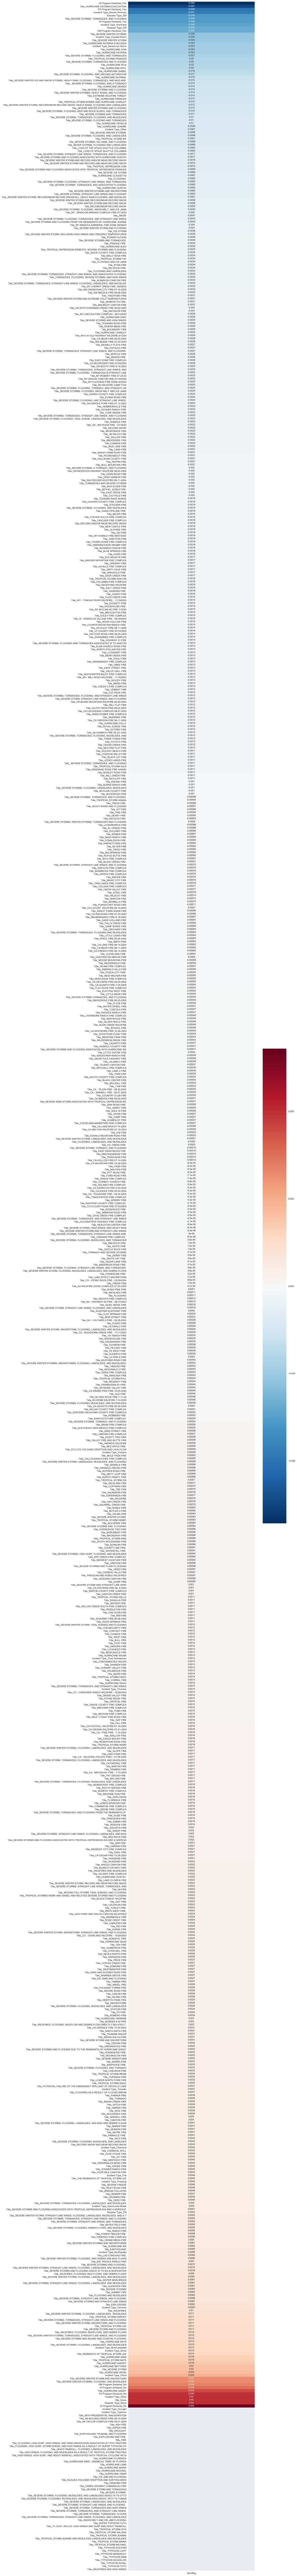

In [28]:
plt.figure(figsize=(12,200))
corr = df.corr().loc[col_categorical_dummies_list, "EarnBeg"]
sns.heatmap(corr.to_frame()[["EarnBeg"]].sort_values("EarnBeg"), annot=True)

### Texas Model

In [29]:
df_tx = df.loc[df["state_abv"] == "TX"]

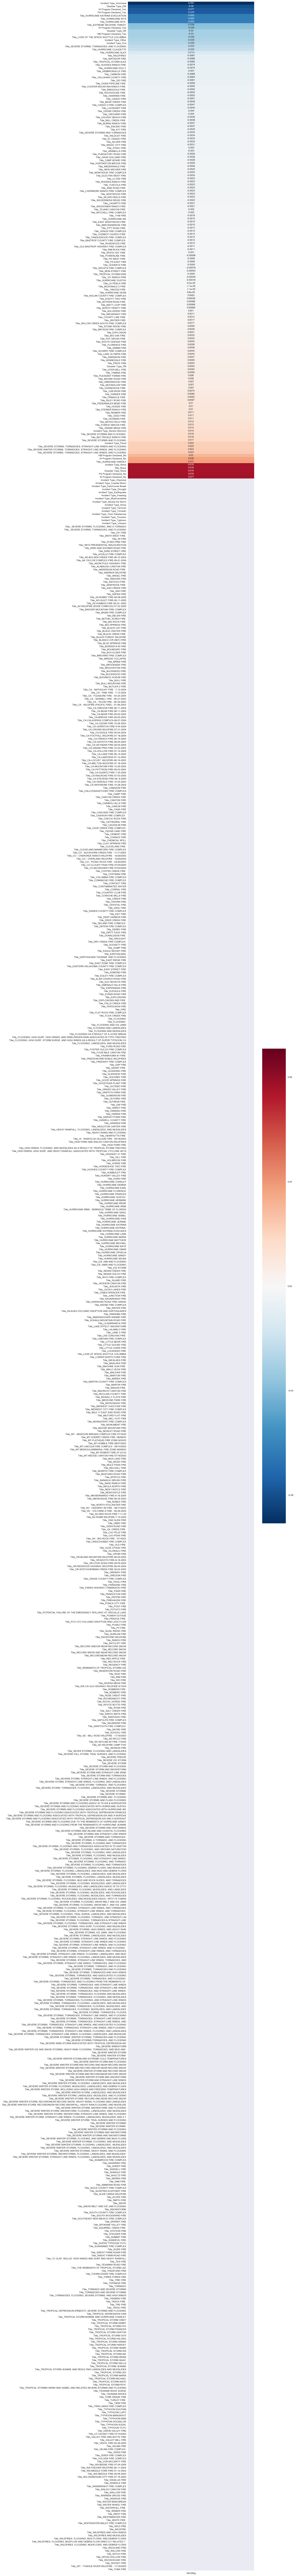

In [30]:
# checking the correlation between EarnBeg and our categorical data
plt.figure(figsize=(12,200))
corr_tx = df_tx.corr().loc[col_categorical_dummies_list, "EarnBeg"]
sns.heatmap(corr_tx.to_frame()[["EarnBeg"]].sort_values("EarnBeg"), annot=True)

In [31]:
df_tx["EarnBeg"].fillna(0, inplace=True)

C:\Users\Trisarah\Anaconda3\envs\dsi\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [32]:
df_tx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16037 entries, 157160 to 173196
Columns: 878 entries, state_abv to Title_YUBA FIRE
dtypes: datetime64[ns](3), float64(29), object(11), uint8(835)
memory usage: 18.2+ MB


In [33]:
X = df_tx[col_categorical_dummies_list]
y = df_tx["EarnBeg"]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### Logistic Regression Using GridSearchCV 

In [35]:
logreg = LogisticRegression()
kf = KFold(n_splits=5, shuffle=True)
params = {'penalty':['l1','l2'],
          'C':np.logspace(-10,0,10),
          'class_weight': [None, "balanced"]
         }

grid = GridSearchCV(logreg, param_grid=params, cv=kf)

grid.fit(X_train,y_train)

print(grid.best_score_)
print(grid.best_params_)

0.0011640475596574374
{'C': 3.5938136638046256e-05, 'class_weight': None, 'penalty': 'l2'}


#### RandomForrest Classifier with GridSearch CV 

In [36]:
param_grid = {"n_estimators": [200, 500],
    "max_depth": [3, None],
    "max_features": [1, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [True, False]}

model = RandomForestRegressor(random_state=0)
grid2 = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid2.fit(X_train, y_train)

print(grid2.best_score_)
print(grid2.best_params_)

0.03220763162546388
{'bootstrap': True, 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}


## Florida Model

In [37]:
df_fl = df.loc[df["state_abv"] == "FL"]


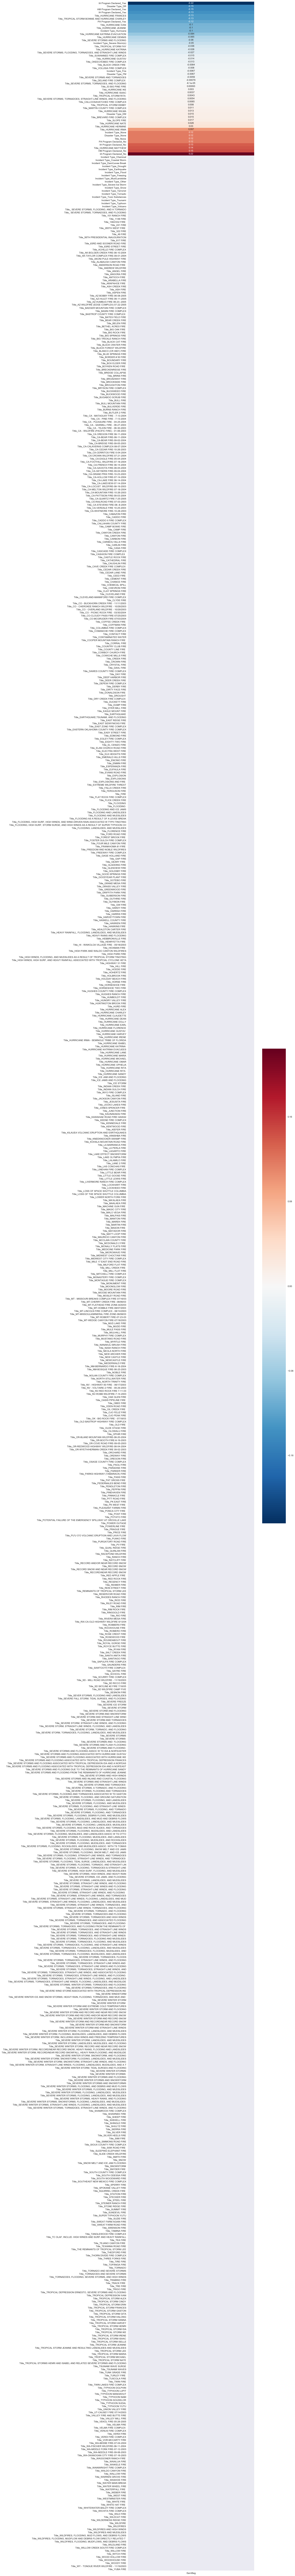

In [38]:
# checking the correlation between EarnBeg and our categorical data
plt.figure(figsize=(12,200))
corr_fl = df_fl.corr().loc[col_categorical_dummies_list, "EarnBeg"]
sns.heatmap(corr_fl.to_frame()[["EarnBeg"]].sort_values("EarnBeg"), annot=True)

In [39]:
df_fl["EarnBeg"].fillna(0, inplace=True)

C:\Users\Trisarah\Anaconda3\envs\dsi\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [40]:
X = df_fl[col_categorical_dummies_list]
y = df_fl["EarnBeg"]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### Logistic Regression Using GridSearchCV 

In [42]:
logreg = LogisticRegression()
kf = KFold(n_splits=5, shuffle=True)
params = {'penalty':['l1','l2'],
          'C':np.logspace(-10,0,10),
          'class_weight': [None, "balanced"]
         }

grid = GridSearchCV(logreg, param_grid=params, cv=kf)

grid.fit(X_train,y_train)

print(grid.best_score_)
print(grid.best_params_)

0.006697108066971081
{'C': 1.0, 'class_weight': None, 'penalty': 'l1'}


#### RandomForrest Classifier with GridSearch CV 

In [43]:
param_grid = {"n_estimators": [200, 500],
    "max_depth": [3, None],
    "max_features": [1, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [True, False]}

model = RandomForestRegressor(random_state=0)
grid2 = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid2.fit(X_train, y_train)

print(grid2.best_score_)
print(grid2.best_params_)

0.20483413330929223
{'bootstrap': False, 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}


## Louisiana Model

In [44]:
df_la = df.loc[df["state_abv"] == "LA"]

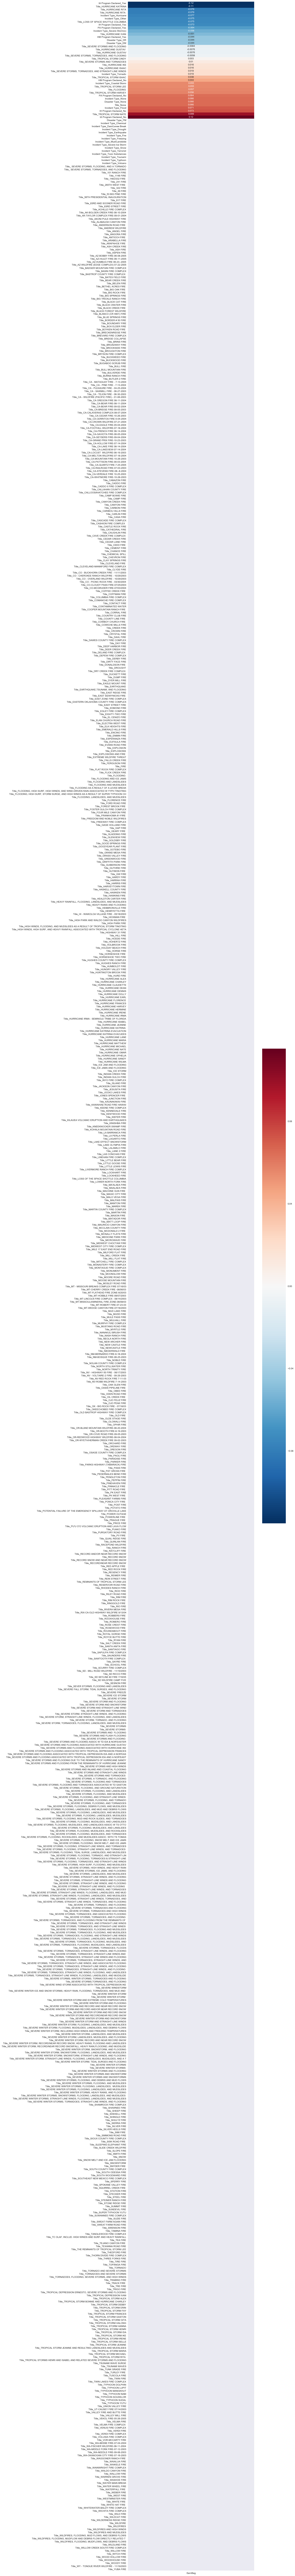

In [45]:
# checking the correlation between EarnBeg and our categorical data
plt.figure(figsize=(12,200))
corr_la= df_la.corr().loc[col_categorical_dummies_list, "EarnBeg"]
sns.heatmap(corr_la.to_frame()[["EarnBeg"]].sort_values("EarnBeg"), annot=True)

In [46]:
df_la["EarnBeg"].fillna(0, inplace=True)
X = df_la[col_categorical_dummies_list]
y = df_la["EarnBeg"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

C:\Users\Trisarah\Anaconda3\envs\dsi\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


#### Logistic Regression Using GridSearchCV 

In [47]:
logreg = LogisticRegression()
kf = KFold(n_splits=5, shuffle=True)
params = {'penalty':['l1','l2'],
          'C':np.logspace(-10,0,10),
          'class_weight': [None, "balanced"]
         }

grid = GridSearchCV(logreg, param_grid=params, cv=kf)

grid.fit(X_train,y_train)

print(grid2.best_score_)
print(grid2.best_params_)

0.20483413330929223
{'bootstrap': False, 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}


#### RandomForrest Classifier with GridSearch CV 

In [48]:
param_grid = {"n_estimators": [200, 500],
    "max_depth": [3, None],
    "max_features": [1, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [True, False]}

model = RandomForestRegressor(random_state=0)
grid2 = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid2.fit(X_train, y_train)

print(grid2.best_score_)
print(grid2.best_params_)

0.045087675981151154
{'bootstrap': True, 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


## California Model

In [49]:
df_ca = df.loc[df["state_abv"] == "CA"]

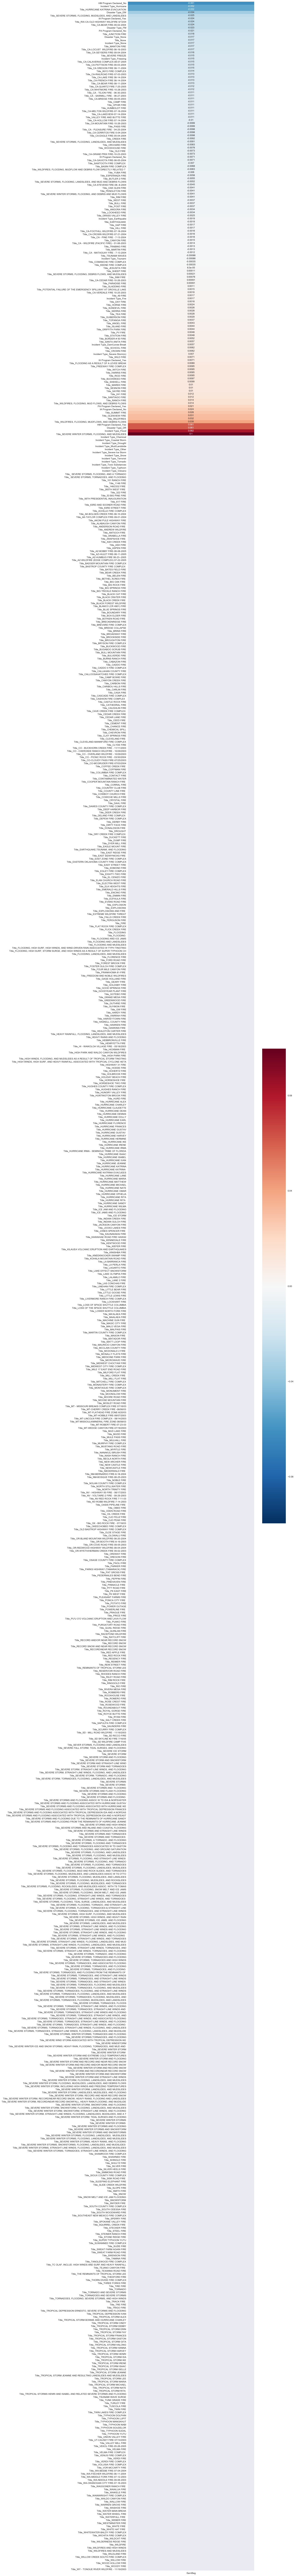

In [50]:
# checking the correlation between EarnBeg and our categorical data
plt.figure(figsize=(12,200))
corr_ca = df_ca.corr().loc[col_categorical_dummies_list, "EarnBeg"]
sns.heatmap(corr_ca.to_frame()[["EarnBeg"]].sort_values("EarnBeg"), annot=True)

In [51]:
df_ca["EarnBeg"].fillna(0, inplace=True)

X = df_ca[col_categorical_dummies_list]
y = df_ca["EarnBeg"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

C:\Users\Trisarah\Anaconda3\envs\dsi\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


#### Logistic Regression Using GridSearchCV 

In [52]:
logreg = LogisticRegression()
kf = KFold(n_splits=5, shuffle=True)
params = {'penalty':['l1','l2'],
          'C':np.logspace(-10,0,10),
          'class_weight': [None, "balanced"]
         }

grid = GridSearchCV(logreg, param_grid=params, cv=kf)

grid.fit(X_train,y_train)

print(grid.best_score_)
print(grid.best_params_)

0.005162241887905605
{'C': 1.0, 'class_weight': None, 'penalty': 'l1'}


#### RandomForrest Classifier with GridSearch CV 

In [53]:
param_grid = {"n_estimators": [200, 500],
    "max_depth": [3, None],
    "max_features": [1, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [True, False]}

model = RandomForestRegressor(random_state=0)
grid2 = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid2.fit(X_train, y_train)

print(grid2.best_score_)
print(grid2.best_params_)

0.004569193327913576
{'bootstrap': True, 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
